<h1 style="color:Blue;">Thyroid Prediction Model</h1>

In [ ]:
<img src="images/Thyroid.png" alt="Image About Thyroid" width="200" height="300">

In [1]:
###  Predictive analysis template for an attached CSV (thyroid.csv)

###  - Loads the file
###  - Auto-detects a plausible target column
###  - Handles preprocessing for numeric & categorical features
###  - Trains baseline models (classification or regression depending on target type)
###  - Evaluates with clear metrics
###  - Produces multiple Matplotlib charts (no seaborn, one plot per figure, no explicit colors)
###  - Saves trained model and metrics to /mnt/data for download
### 
###  This script is defensive: it tries to "do the right thing" regardless of schema.
###  You can safely re-run it after tweaking TARGET_COLUMN below if you prefer a different target.

<h2 style="color:blue;">Install Packages / Libraries</h2>

In [2]:
# Importing Libraries:
import subprocess, sys

packages = ["scikit-learn", "matplotlib", "numpy", "pandas", "seaborn"]

for pkg in packages:
    print(f"📦 Installing {pkg} ...", end="", flush=True)
    subprocess.run(
        [sys.executable, "-m", "pip", "install", pkg, "-q"],
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )
    print(" ✅")

# !pip install scikit-learn --force-reinstall -q > /dev/null 2>&1
# !pip install matplotlib --force-reinstall -q > /dev/null 2>&1
# !pip install pandas --force-reinstall -q > /dev/null 2>&1
# !pip install numpy --force-reinstall -q > /dev/null 2>&1
# !pip install seaborn --force-reinstall -q > /dev/null 2>&1


📦 Installing scikit-learn ... ✅
📦 Installing matplotlib ... ✅
📦 Installing numpy ... ✅
📦 Installing pandas ... ✅
📦 Installing seaborn ... ✅


In [3]:
##  Import the required Libraries
import os
import pandas as pd
import math

# -------------          Statistics Libraries          -------------     
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
                            roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, \
                            r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# Checking sklearn version
import sklearn
print(f"sklearn Version: {sklearn.__version__}")
#
import seaborn as sns
# ------------------------------------------------------------------

#------------------------------------------------------------------
#-------------          Other Libraries               -------------  
#------------------------------------------------------------------
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any

import joblib


sklearn Version: 1.7.2


<h2 style="color:red;">Configuration</h2>

In [4]:
# CSV Path Location
DATA_PATH = './datasets/thyroid.csv'

# Output Data Analysis
OUTPUT_DIR = Path("./analysis/thyroid_analysis_outputs")
# Conf Directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
#
# Optionally hard-set the target (uncomment & set if you already know it)
TARGET_COLUMN = None  # e.g., "target"

In [5]:
#Read Thyroid CSV File
tdata = pd.read_csv('./datasets/thyroid.csv')

<h2 style="color:red;">Functions</h2>

<h3 style="color:Blue;">choose_target_column</h3>

In [6]:
def choose_target_column(df: pd.DataFrame) -> Tuple[str, str]:
    """
        Choose a plausible target column from the dataframe.
        Returns: (target_col, problem_type) where problem_type ∈ {"classification","regression"}
        Heuristics:
              1) Prefer common names: ['target','class','label','diagnosis','outcome','y']
              2) Otherwise, pick a column with small cardinality (2..10 unique) => classification
              3) Otherwise, pick the last column; determine type by numeric vs non-numeric
    """
    candidates = [c for c in df.columns if c.lower() in
              ["target", "class", "label", "diagnosis", "outcome", "y"]]

    for c in candidates:
        nuniq = df[c].nunique(dropna=True)
        if 2 <= nuniq <= 10:
            return c, "classification"

        if pd.api.types.is_numeric_dtype(df[c]):
            return c, "regression"
        return c, "classification"

    small_card_cols = []
    for c in candidates:
        if c == df.columns[0]:
            continue

        nuniq = df[c].nunique(dropna=True)

        if 2 <= nuniq <= 10:
            small_card_cols.append((c, nuniq))
    if small_card_cols:
        small_card_cols.sort(key=lambda x: x[1])
        return small_card_cols[0][0], "classification"

    c = df.columns[-1]
    if pd.api.types.is_numeric_dtype(df[c]):
        if df[c].nunique(dropna=True) > 15:
            return c, "regression"
        return c, "classification"
    else:
        return c, "classification"
   

<h3 style="color:Blue;">split_features_target</h3>

In [7]:
def split_features_target(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    y = df[target_col]
    X = df.drop(columns=[target_col])
    return X, y

<h3 style="color:Blue;">_make_ohe</h3>

In [8]:
from sklearn.preprocessing import OneHotEncoder
def _make_ohe():
    try:
        # scikit-learn >= 1.2 (usa sparse_output)
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # scikit-learn <= 1.1 (usa sparse)
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

<h3 style="color:Blue;">build_preprocessor</h3>

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
def build_preprocessor(X: pd.DataFrame) -> Tuple[ColumnTransformer, List[str], List[str]]:
    numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_features = [c for c in X.columns if c not in numeric_features]

    numeric_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    # categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))])

    categorical_transformer = Pipeline(steps=[("onehot", _make_ohe())])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ],
        remainder="drop"
    )
    return preprocessor, numeric_features, categorical_features

<h3 style="color:Blue;">plot_roc_curve_binary</h3>

In [10]:
def plot_roc_curve_binary(y_true, y_proba, title: str, out_path: Path):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

<h3 style="color:Blue;">plot_confusion</h3>

In [11]:
def plot_confusion(y_true, y_pred, title: str, out_path: Path, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure()
    disp.plot(values_format="d")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

<h3 style="color:Blue;">plot_feature_importance</h3>

In [12]:
def plot_feature_importance(model, feature_names: List[str], top_k: int, title: str, out_path: Path):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        idx = np.argsort(importances)[::-1][:top_k]
        plt.figure()
        plt.bar(range(len(idx)), importances[idx])
        plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=90)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(out_path)
        plt.show()


<h3 style="color:Blue;">plot_scatter_true_pred</h3>

In [13]:
def plot_scatter_true_pred(y_true, y_pred, title: str, out_path: Path):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.7)
    min_v = min(np.min(y_true), np.min(y_pred))
    max_v = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

<h3 style="color:Blue;">plot_residuals_hist</h3>

In [14]:
def plot_residuals_hist(y_true, y_pred, title: str, out_path: Path):
    residuals = y_true - y_pred
    plt.figure()
    plt.hist(residuals, bins=30)
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()


<h3 style="color:Blue;">expanded_feature_names</h3>

In [15]:
def expanded_feature_names(preprocessor: ColumnTransformer) -> List[str]:
    names: List[str] = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            ohe = trans.named_steps["onehot"]
            if hasattr(ohe, "get_feature_names_out"):
                names.extend(ohe.get_feature_names_out(cols).tolist())
            else:
                names.extend([f"{c}__encoded" for c in cols])
        else:
            if isinstance(cols, list):
                names.extend(cols)
            else:
                names.append(cols)
    return names


<h3 style="color:Blue;">summarize_missing</h3>

In [16]:
def summarize_missing(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum().sort_values(ascending=False)
    pct = (df.isna().mean().sort_values(ascending=False) * 100.0).round(2)
    summary = pd.DataFrame({"missing_count": miss, "missing_pct": pct})
    summary = summary[summary["missing_count"] > 0]
    return summary

<h2 style="color:#1E90FF; animation:colorBlink 1s infinite;">
🚀 Attention: Loading CSV Data!
</h2>

<style>
@keyframes colorBlink {
  0% { color: #1E90FF; }
  50% { color: #FF1493; }
  100% { color: #1E90FF; }
}
</style>


<h3>
<span style="animation:blink 1s infinite;">🔴</span>
<span>Training in progress...</span>
</h3>

<style>
@keyframes blink {
  50% { opacity: 0; }
}
</style>


<style>
@keyframes blink {
  50% { opacity: 0; }
}
.blink {
  animation: blink 1s infinite;
  color: red;
  font-weight: bold;
}
</style>

<h3 class="blink">⚡ Analyzing data...</h3>
<p class="blink">⏳ Please wait for the processing to finish.</p>

Preview:
   Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
0   27      F      No         No              No        Euthyroid   
1   34      F      No        Yes              No        Euthyroid   
2   30      F      No         No              No        Euthyroid   
3   62      F      No         No              No        Euthyroid   
4   62      F      No         No              No        Euthyroid   

          Physical Examination Adenopathy       Pathology     Focality Risk  \
0   Single nodular goiter-left         No  Micropapillary    Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary    Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
4          Multinodular goiter         No  Micropapillary  Multi-Focal  Low   

     T   N   M Stage       Response Recurred  
0  T1a  N0  M0     I  Indeterminate       No  
1  T1a 

<Figure size 640x480 with 0 Axes>

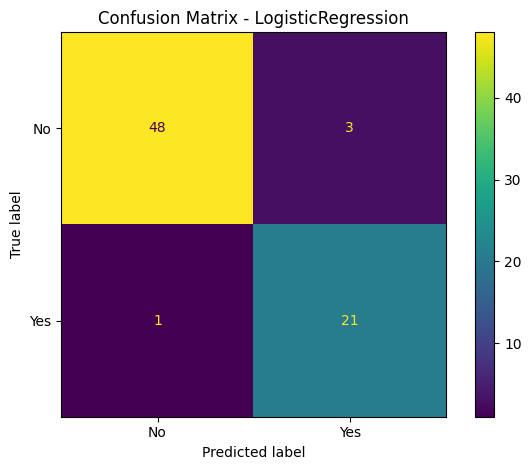

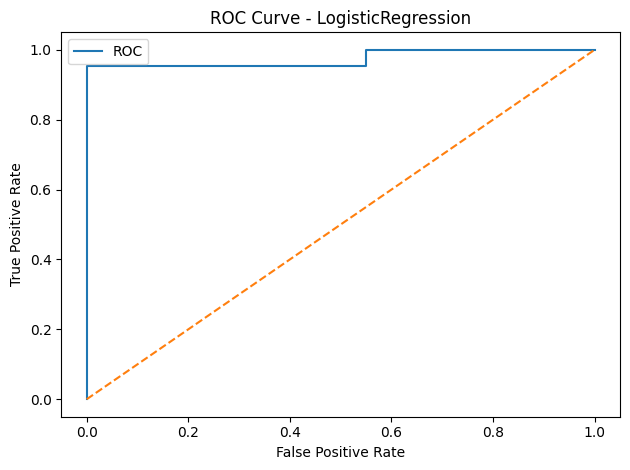

<Figure size 640x480 with 0 Axes>

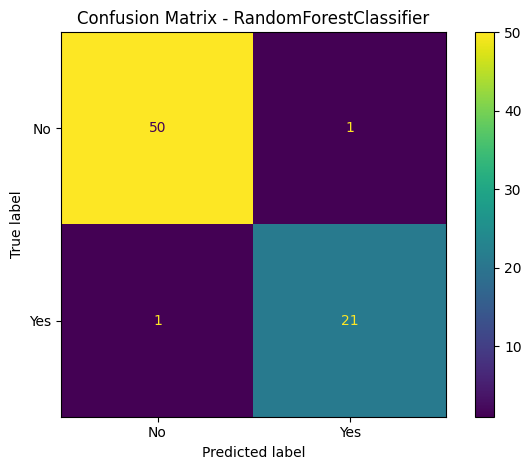

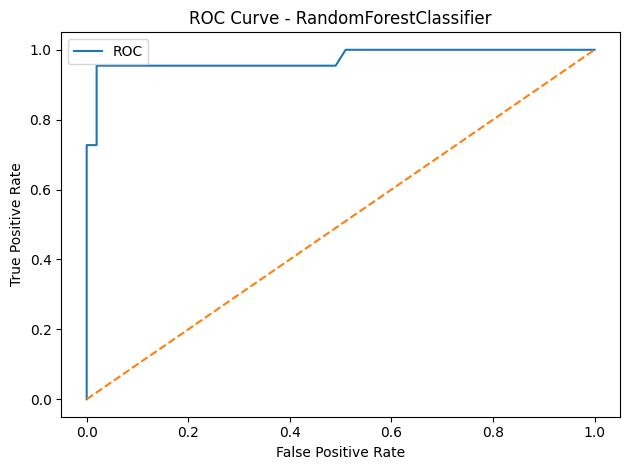

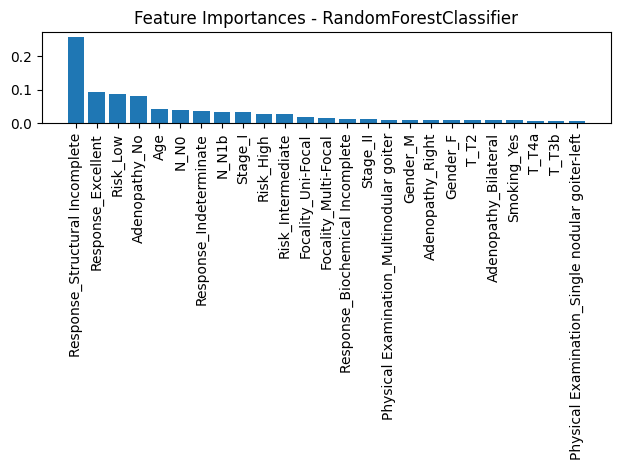

Done. Outputs in: analysis\thyroid_analysis_outputs


In [17]:
from sklearn.pipeline import Pipeline
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

print("Preview:")
print(df.head())

# -----------------------------
# Target detection
# -----------------------------
if TARGET_COLUMN is None:
    target_col, problem_type = choose_target_column(df)
else:
    target_col = TARGET_COLUMN
    if pd.api.types.is_numeric_dtype(df[target_col]):
        if df[target_col].nunique(dropna=True) > 15:
            problem_type = "regression"
        else:
            problem_type = "classification"
    else:
        problem_type = "classification"

print(f"Detected target: {target_col} | Problem: {problem_type}")

# -----------------------------
# Basic EDA and cleaning
# -----------------------------
missing_summary = summarize_missing(df)
if not missing_summary.empty:
    print("\nMissing values summary:")
    print(missing_summary.head(20))

df = df.dropna(subset=[target_col]).copy()

dup_count = df.duplicated().sum()
if dup_count > 0:
    df = df.drop_duplicates().copy()
    print(f"Removed {dup_count} duplicate rows")

# -----------------------------
# Train / Test split
# -----------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

preprocessor, num_cols, cat_cols = build_preprocessor(X)

if problem_type == "classification" and y.nunique() > 1:
    test_size = 0.2 if df.shape[0] > 50 else 0.3
    stratify = y
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=stratify
    )
else:
    test_size = 0.2 if df.shape[0] > 50 else 0.3
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

metrics_records: List[Dict[str, Any]] = []

if problem_type == "classification":
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForestClassifier": RandomForestClassifier(n_estimators=300, random_state=42)
    }

    for name, clf in models.items():
        pipe = Pipeline(steps=[("prep", preprocessor), ("model", clf)])
        if y_train.nunique() > 1:
            cv = StratifiedKFold(n_splits=min(5, y_train.value_counts().min() if y_train.value_counts().min() >= 2 else 2), shuffle=True, random_state=42)
            try:
                cv_acc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
                cv_f1 = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_weighted")
                cv_mean_acc = float(np.mean(cv_acc))
                cv_mean_f1 = float(np.mean(cv_f1))
            except Exception as e:
                cv_mean_acc, cv_mean_f1 = np.nan, np.nan
        else:
            cv_mean_acc, cv_mean_f1 = np.nan, np.nan

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        roc_auc = np.nan
        if y.nunique() == 2:
            try:
                if hasattr(pipe.named_steps["model"], "predict_proba"):
                    y_proba = pipe.predict_proba(X_test)[:, 1]
                elif hasattr(pipe.named_steps["model"], "decision_function"):
                    y_proba = pipe.decision_function(X_test)
                    y_proba = (y_proba - np.min(y_proba)) / (np.max(y_proba) - np.min(y_proba) + 1e-9)
                else:
                    y_proba = None
                if y_proba is not None:
                    y_true_bin = pd.Series(y_test).astype("category").cat.codes
                    roc_auc = roc_auc_score(y_true_bin, y_proba)
            except Exception:
                roc_auc = np.nan

        metrics_records.append({
            "model": name,
            "cv_accuracy_mean": cv_mean_acc,
            "cv_f1_weighted_mean": cv_mean_f1,
            "test_accuracy": acc,
            "test_precision_weighted": prec,
            "test_recall_weighted": rec,
            "test_f1_weighted": f1,
            "test_roc_auc_binary": roc_auc
        })

        labels = np.unique(y_test)
        cm_path = OUTPUT_DIR / f"confusion_matrix_{name}.png"
        try:
            plt.close('all')
            cm = confusion_matrix(y_test, y_pred, labels=labels)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            fig_cm = plt.figure()
            disp.plot(values_format="d")
            plt.title(f"Confusion Matrix - {name}")
            plt.tight_layout()
            fig_cm.savefig(cm_path)
            plt.show()
        except Exception:
            pass

        if (y.nunique() == 2) and not np.isnan(roc_auc):
            try:
                if hasattr(pipe.named_steps["model"], "predict_proba"):
                    y_proba = pipe.predict_proba(X_test)[:, 1]
                elif hasattr(pipe.named_steps["model"], "decision_function"):
                    y_proba = pipe.decision_function(X_test)
                    y_proba = (y_proba - np.min(y_proba)) / (np.max(y_proba) - np.min(y_proba) + 1e-9)
                else:
                    y_proba = None
                if y_proba is not None:
                    roc_path = OUTPUT_DIR / f"roc_curve_{name}.png"
                    plt.close('all')
                    fpr, tpr, _ = roc_curve(pd.Series(y_test).astype("category").cat.codes, y_proba)
                    plt.figure()
                    plt.plot(fpr, tpr, label="ROC")
                    plt.plot([0, 1], [0, 1], linestyle="--")
                    plt.xlabel("False Positive Rate")
                    plt.ylabel("True Positive Rate")
                    plt.title(f"ROC Curve - {name}")
                    plt.legend()
                    plt.tight_layout()
                    plt.savefig(roc_path)
                    plt.show()
            except Exception:
                pass

        try:
            pipe.fit(X_train, y_train)
            names: List[str] = []
            for tname, trans, cols in pipe.named_steps["prep"].transformers_:
                if tname == "remainder" and trans == "drop":
                    continue
                if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
                    ohe = trans.named_steps["onehot"]
                    names.extend(ohe.get_feature_names_out(cols).tolist())
                else:
                    names.extend(cols if isinstance(cols, list) else [cols])
            if hasattr(pipe.named_steps["model"], "feature_importances_"):
                fi_path = OUTPUT_DIR / f"feature_importances_{name}.png"
                importances = pipe.named_steps["model"].feature_importances_
                idx = np.argsort(importances)[::-1][:min(25, len(importances))]
                plt.close('all')
                plt.figure()
                plt.bar(range(len(idx)), importances[idx])
                plt.xticks(range(len(idx)), [names[i] for i in idx], rotation=90)
                plt.title(f"Feature Importances - {name}")
                plt.tight_layout()
                plt.savefig(fi_path)
                plt.show()
        except Exception:
            pass

        model_path = OUTPUT_DIR / f"model_{name}.joblib"
        try:
            joblib.dump(pipe, model_path)
        except Exception:
            pass

    metrics_df = pd.DataFrame(metrics_records).sort_values(by="test_f1_weighted", ascending=False)
    best_model_name = metrics_df.iloc[0]["model"]
    # Correction - Romi Lemes
    best_pipe = Pipeline(steps=[("prep", preprocessor),
                               ("model", models[best_model_name])])
    best_pipe.fit(X_train, y_train)
    y_pred_best = best_pipe.predict(X_test)
    report_text = classification_report(y_test, y_pred_best, zero_division=0)
    report_path = OUTPUT_DIR / "classification_report.txt"
    with open(report_path, "w", encoding="utf-8") as f:
        f.write(report_text)

    metrics_csv_path = OUTPUT_DIR / "metrics_classification.csv"
    metrics_df.to_csv(metrics_csv_path, index=False)

else:
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForestRegressor": RandomForestRegressor(n_estimators=300, random_state=42)
    }
    for name, reg in models.items():
        # last Version
        # pipe = Pipeline(steps=[("prep", preprocessor), ("model", reg)])
        # New Version - 20251030
        pipe = Pipeline(steps=[
            ("prep", preprocessor),
            ("model", LogisticRegression(max_iter=1000))
        ])

        cv = KFold(n_splits=5 if len(X_train) >= 50 else 3, shuffle=True, random_state=42)
        try:
            cv_r2 = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2")
            cv_mae = -cross_val_score(pipe, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error")
            cv_mean_r2 = float(np.mean(cv_r2))
            cv_mean_mae = float(np.mean(cv_mae))
        except Exception:
            cv_mean_r2, cv_mean_mae = np.nan, np.nan

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred) ** 0.5

        metrics_records.append({
            "model": name,
            "cv_r2_mean": cv_mean_r2,
            "cv_mae_mean": cv_mean_mae,
            "test_r2": r2,
            "test_mae": mae,
            "test_rmse": rmse
        })

        scatter_path = OUTPUT_DIR / f"true_vs_pred_{name}.png"
        try:
            plt.close('all')
            plt.figure()
            plt.scatter(y_test, y_pred, alpha=0.7)
            min_v = min(np.min(y_test), np.min(y_pred))
            max_v = max(np.max(y_test), np.max(y_pred))
            plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
            plt.xlabel("True")
            plt.ylabel("Predicted")
            plt.title(f"True vs Predicted - {name}")
            plt.tight_layout()
            plt.savefig(scatter_path)
            plt.show()
        except Exception:
            pass

        resid_path = OUTPUT_DIR / f"residuals_hist_{name}.png"
        try:
            plt.close('all')
            residuals = y_test - y_pred
            plt.figure()
            plt.hist(residuals, bins=30)
            plt.xlabel("Residual")
            plt.ylabel("Frequency")
            plt.title(f"Residuals Histogram - {name}")
            plt.tight_layout()
            plt.savefig(resid_path)
            plt.show()
        except Exception:
            pass

        try:
            pipe.fit(X_train, y_train)
            names: List[str] = []
            for tname, trans, cols in pipe.named_steps["prep"].transformers_:
                if tname == "remainder" and trans == "drop":
                    continue
                if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
                    ohe = trans.named_steps["onehot"]
                    names.extend(ohe.get_feature_names_out(cols).tolist())
                else:
                    names.extend(cols if isinstance(cols, list) else [cols])
            if hasattr(pipe.named_steps["model"], "feature_importances_"):
                fi_path = OUTPUT_DIR / f"feature_importances_{name}.png"
                importances = pipe.named_steps["model"].feature_importances_
                idx = np.argsort(importances)[::-1][:min(25, len(importances))]
                plt.close('all')
                plt.figure()
                plt.bar(range(len(idx)), importances[idx])
                plt.xticks(range(len(idx)), [names[i] for i in idx], rotation=90)
                plt.title(f"Feature Importances - {name}")
                plt.tight_layout()
                plt.savefig(fi_path)
                plt.show()
        except Exception:
            pass

        model_path = OUTPUT_DIR / f"model_{name}.joblib"
        try:
            joblib.dump(pipe, model_path)
        except Exception:
            pass

    metrics_df = pd.DataFrame(metrics_records).sort_values(by="test_r2", ascending=False)
    metrics_csv_path = OUTPUT_DIR / "metrics_regression.csv"
    metrics_df.to_csv(metrics_csv_path, index=False)

print("Done. Outputs in:", OUTPUT_DIR)